In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from IPython.display import Latex

import numpy as np
import matplotlib.pyplot as plt
import random
import os

from scripts.utils import *
from scripts.burgers_numeric import *
from scripts.burgers_nn import *
from scripts.models import *

In [2]:
from matplotlib import colors

cdict = {'red':   ((0.0,  0.22, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  0.89, 1.0)),

         'green': ((0.0,  0.49, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  0.12, 1.0)),

         'blue':  ((0.0,  0.72, 0.0),
                   (0.5,  0.0, 0.0),
                   (1.0,  0.11, 1.0))}

cmap = colors.LinearSegmentedColormap('custom', cdict)

## Load data

In [3]:
f_data, u_data = torch.load('data/burgers_dataset')
print(f_data.shape, u_data.shape)

torch.Size([500, 128]) torch.Size([60, 500, 11, 128])


In [4]:
#setting parameters
Nu0 = u_data.size()[0]
Nf = u_data.size()[1]
num_t = u_data.size()[2]-1
s = u_data.size()[3]

Ndata = Nu0*Nf*num_t

##num_interior=128 // num_pts=130=0,dx,...,129*dx // dx=1/129
xmin = 0.0; xmax = 1.0
delta_x = (xmax-xmin)/(s+1)
x = torch.linspace(xmin+delta_x,xmax-delta_x,s)

# num_interior=9 // num_pts=11=0,dt,...,10*dt // dt=1/10
num_t=10 #(= 1/0.1)
tmin = 0.0; tmax = 1.0
delta_t = (tmax-tmin)/num_t
t = torch.linspace(tmin,tmax,num_t+1)

num_t_numeric=100 #(= 1/0.01)
delta_t_numeric = (tmax-tmin)/num_t_numeric

In [5]:
class Burgers_Dataset(Dataset): 
        def __init__(self, f_data, u_data):
            f_data = f_data.reshape(1,-1,1,s).repeat(Nu0,1,num_t,1).reshape(-1,1,s)
            u_t_data = u_data[:,:,:-1].reshape(-1,1,s)
            u_t_dt_data = u_data[:,:,1:].reshape(-1,1,s)

            self.input_data = torch.cat((u_t_data, f_data), 1)
            self.output_data = u_t_dt_data

        def __len__(self):
            return Ndata

        def __getitem__(self, idx): 
            x = torch.FloatTensor(self.input_data[idx])
            y = torch.FloatTensor(self.output_data[idx])
            return x, y
        
Burgers_data=Burgers_Dataset(f_data, u_data)

In [6]:
x_test=Burgers_data.input_data
y_test=Burgers_data.output_data

## Load surrogate model

In [7]:
#load_model
checkpoint = torch.load('logs/burgers_operator_model', map_location=lambda storage, loc: storage)

model_f = Net_f(s)
model_f.load_state_dict(checkpoint['model_f_state_dict'])
model_f.eval()

model_u = Net_u(s)
model_u.load_state_dict(checkpoint['model_u_state_dict'])
model_u.eval()

model_trans = Net_trans()
model_trans.load_state_dict(checkpoint['model_trans_state_dict'])
model_trans.eval()

Net_trans(
  (transition1): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
)

## (1) The results of operator learning during Phase1 to Burgers' equation

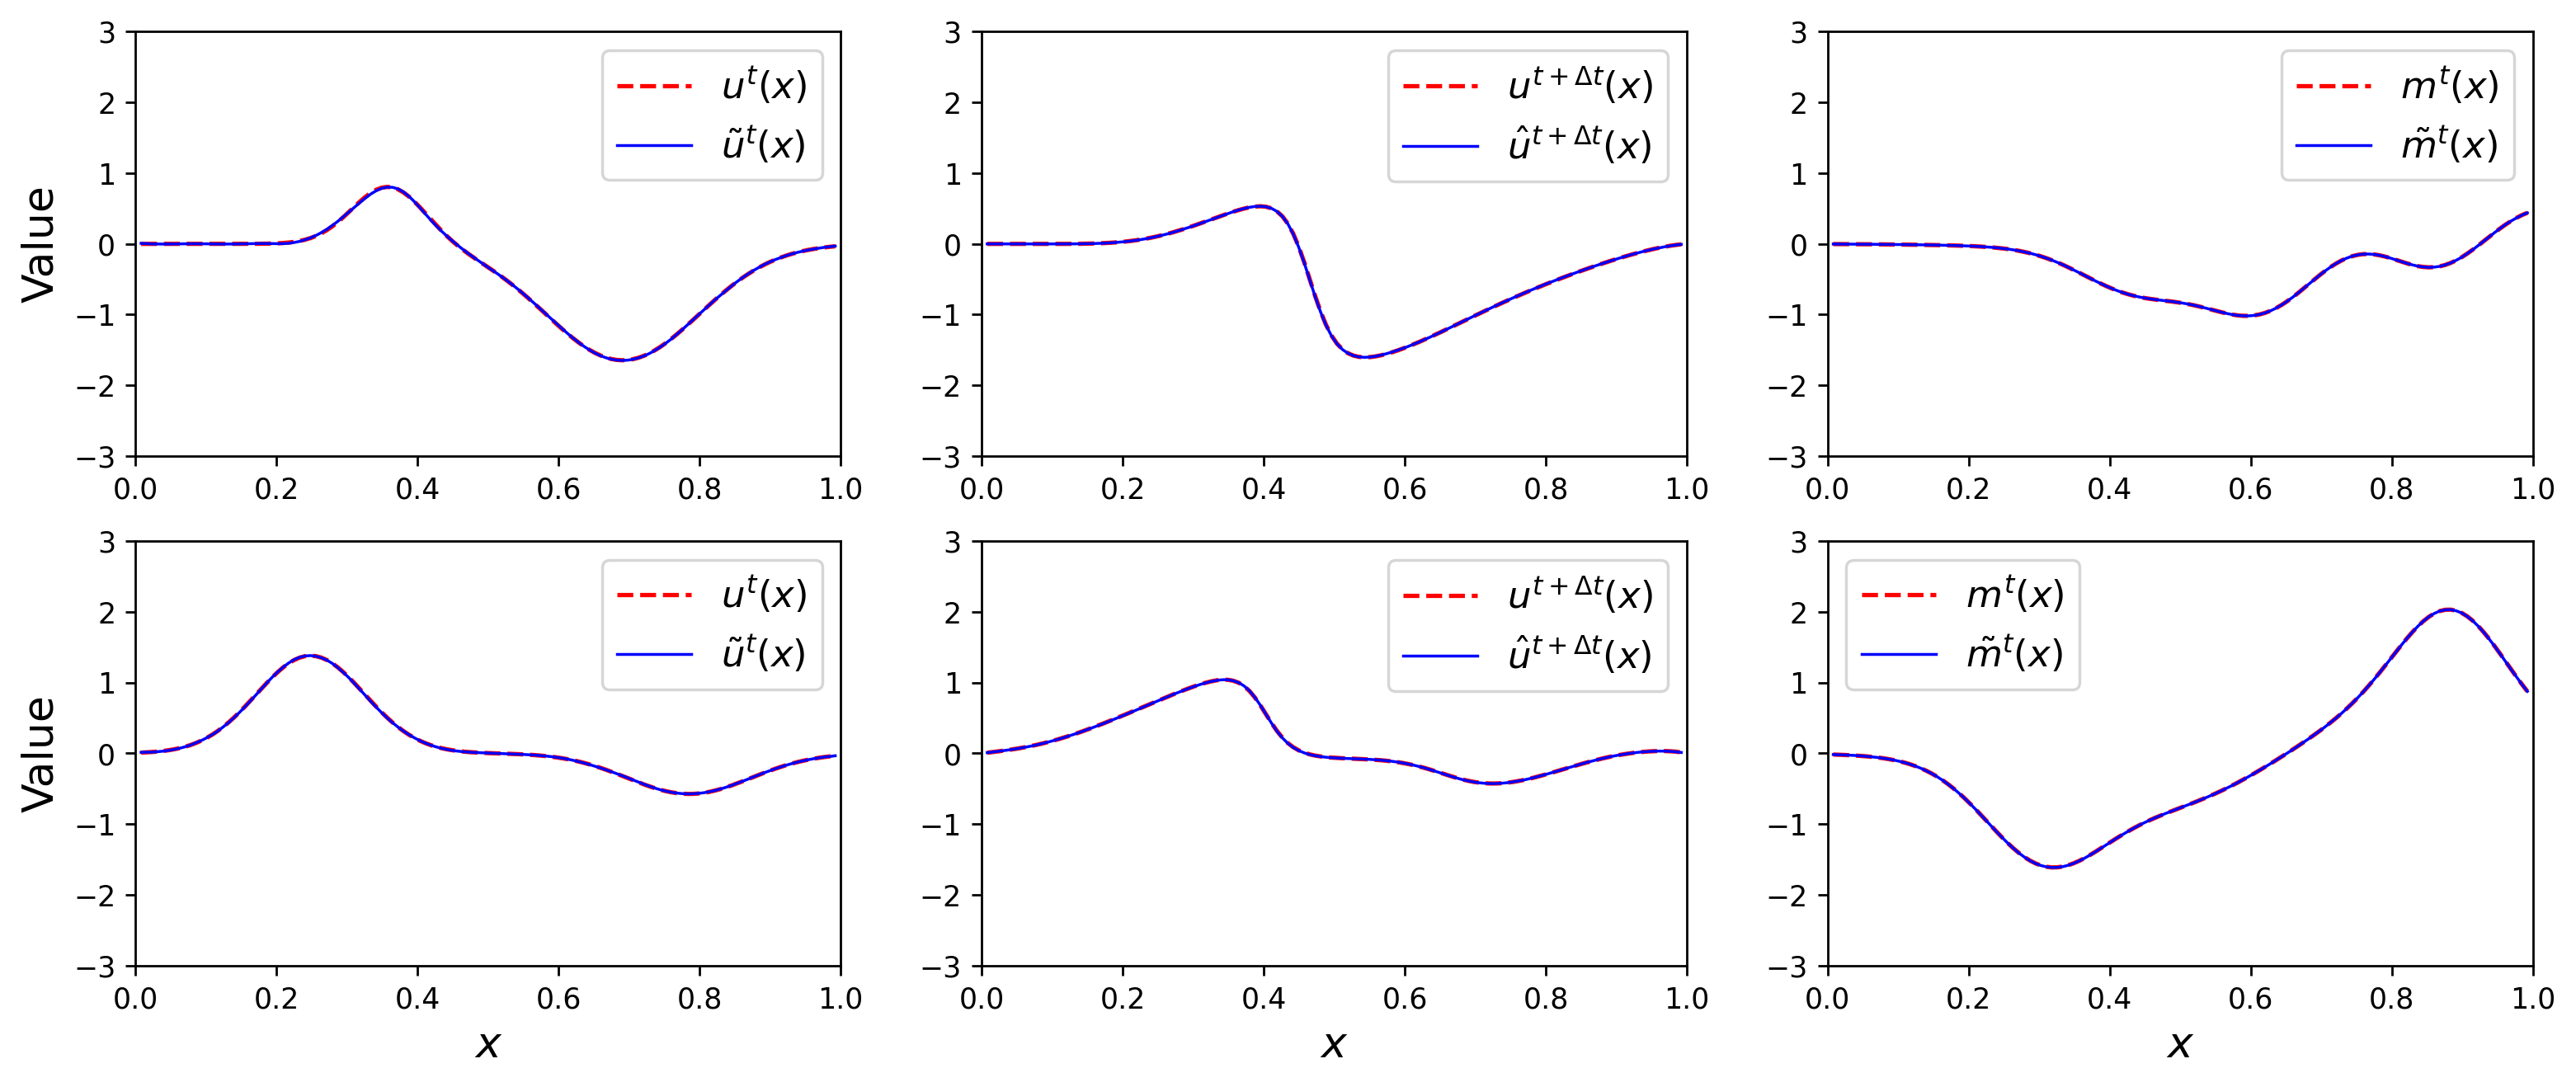

In [8]:
##We choose
idxs=[15210,1520]


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,6), dpi=250)
ax=ax.flatten()

for _, idx in enumerate(idxs):
    f_rec, f_latent = model_f(x_test[[idx]][:,[1],:])
    u_t_rec, u_t_latent = model_u(x_test[[idx]][:,[0],:])
    __, u_t_dt_latent = model_u(y_test[[idx]])
    nn_u_t_dt_latent = model_trans(torch.cat((u_t_latent.view(-1,8,s//4), f_latent.view(-1,8,s//4)), 1))

    u_t_dt_rec = model_u.up(nn_u_t_dt_latent)
    
    ax[0+_*3].plot(x, x_test[[idx]][:,[0],:].squeeze().cpu(), '--', c='r', label=r'$u^t(x)$')
    ax[0+_*3].plot(x, u_t_rec.squeeze().detach().cpu(), c='b', linewidth=1, label=r'$\tilde{u}^t(x)$')
    ax[0+_*3].set_xlim(0,1)
    ax[0+_*3].set_ylim(-3,3)
    ax[0+_*3].legend(fontsize=13)
    ax[0+_*3].set_ylabel("Value", fontsize=15)
    if _ == 1:
        ax[0+_*3].set_xlabel(r'$x$', fontsize=15)
     
    ax[1+_*3].plot(x, y_test[[idx]].squeeze().cpu(), '--', c='r', label=r'$u^{t+\Delta t}(x)$')
    ax[1+_*3].plot(x, u_t_dt_rec.squeeze().detach().cpu(), c='b', linewidth=1, label=r'$\hat{u}^{t+\Delta t}(x)$')
    ax[1+_*3].set_xlim(0,1)
    ax[1+_*3].set_ylim(-3,3)
    ax[1+_*3].legend(fontsize=13)
    if _ == 1:
        ax[1+_*3].set_xlabel(r'$x$', fontsize=15)
        
    ax[2+_*3].plot(x, x_test[[idx]][:,[1],:].squeeze().cpu(), '--', c='r', label=r'$m^t(x)$')
    ax[2+_*3].plot(x, f_rec.squeeze().detach().cpu(), c='b', linewidth=1, label=r'$\tilde{m}^t(x)$')
    ax[2+_*3].set_xlim(0,1)
    ax[2+_*3].set_ylim(-3,3)
    ax[2+_*3].legend(fontsize=13)
    if _ == 1:
        ax[2+_*3].set_xlabel(r'$x$', fontsize=15)

plt.show()

## (2) The results of control optimization during Phase2 to Burgers' equation

In [9]:
name='result_100'
logs = torch.load('logs/{}'.format(name))

In [10]:
loss_eq_target=r'$\frac{1}{2}\int_{\Omega} |u(x, T) - u_d(x)|^2 \, dx$'
loss_eq_force=r'$\frac{\alpha}{2} \int_{\Omega\times[0, T]} |m(x, t)|^2 \, dx dt$'

In [11]:
display()

In [12]:
Latex(r"$J=J_1+J_2=\frac{1}{2}\int_{\Omega} |u(x, T) - u_d(x)|^2dx+\frac{\alpha}{2} \int_{\Omega\times[0, T]} |m(x, t)|^2dx dt$")

<IPython.core.display.Latex object>

In [13]:
Latex(r"The adjoint method:$\\$T={:.3f}$\pm${:.3f},$\\$$J_1$={:.3f}$\pm${:.3f},$\\$$J_2$={:.3f}$\pm${:.3f},$\\$$J$={:.3f}$\pm${:.3f}".format(
    np.mean(logs['t_numerical']), np.std(logs['t_numerical']),
    np.mean(np.array(logs['loss_obj_numerical'])), np.std(np.array(logs['loss_obj_numerical'])),
    np.mean(np.array(logs['loss_f_numerical'])), np.std(np.array(logs['loss_f_numerical'])),
    np.mean(np.array(logs['loss_obj_numerical'])+np.array(logs['loss_f_numerical'])), np.std(np.array(logs['loss_obj_numerical'])+np.array(logs['loss_f_numerical']))
))

<IPython.core.display.Latex object>

In [14]:
Latex(name+r"Our method:$\\$T={:.3f}$\pm${:.3f},$\\$$J_1$={:.3f}$\pm${:.3f},$\\$$J_2$={:.3f}$\pm${:.3f},$\\$$J$={:.3f}$\pm${:.3f}".format(
    np.mean(logs['t_nn']), np.std(logs['t_nn']),
    np.mean(np.array(logs['loss_obj_nn'])), np.std(np.array(logs['loss_obj_nn'])),
    np.mean(np.array(logs['loss_f_nn'])), np.std(np.array(logs['loss_f_nn'])),
    np.mean(np.array(logs['loss_obj_nn'])+np.array(logs['loss_f_nn'])), np.std(np.array(logs['loss_obj_nn'])+np.array(logs['loss_f_nn']))
))

<IPython.core.display.Latex object>

### (2)-1 Sample1

In [15]:
legend_force=['t:{:.1f}~{:.1f}'.format(x, y) for x, y in zip(t[:-1], t[1:])]
legend_state = ['t={}'.format(round(x.item(), 2)) for x in t]

In [16]:
##We choose
idx=5

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=250)
ax=ax.flatten()


#f_const
ax[0].set_title(r'(a) Constant $m^t(x)$', size=15)
ax[0].plot(x,logs['f_const'][idx],'--', c='r', label='Constant F(x)')
ax[0].grid(True, lw=0.4, ls="--", c=".50")
ax[0].set_xlim(0,1)
ax[0].set_ylim(-3,3)
ax[0].set_ylabel(r"Value of $m^t(x)$", fontsize=15)

#f_numeric
ax[1].set_title(r'(b) Optimal $m^t(x)$ (Adjoint method)', size=15)
for i in np.arange(0,100,10):
    ax[1].plot(x,logs['f_numerical'][idx][i], label='t='+str(round(0.1*i,2))+'~'+str(round(0.1*(i+1),2)))
ax[1].grid(True, lw=0.4, ls="--", c=".50")
ax[1].set_xlim(0,1)
ax[1].set_ylim(-3,3)


#f_nn
ax[2].set_title(r'(c) Optimal $m^t(x)$ (Our method)', size=15)
for i in range(num_t):
    ax[2].plot(x,logs['f_nn'][idx][i], label='t='+str(round(0.1*i,2))+'~'+str(round(0.1*(i+1),2)))
ax[2].grid(True, lw=0.4, ls="--", c=".50")
ax[2].set_xlim(0,1)
ax[2].set_ylim(-3,3)
ax[2].legend(legend_force, bbox_to_anchor=(1.05, 0.68), ncol=2)



#u_const
for idx_t in range(num_t+1):
    ax[3].plot(x, logs['u_const'][idx][idx_t], color=cmap(idx_t/(num_t+1)))
ax[3].grid(True, lw=0.4, ls="--", c=".50")
ax[3].set_xlim(0,1)
ax[3].set_ylim(-3,3)  
ax[3].set_ylabel(r"Value of $u^t(x)$", fontsize=15)
ax[3].set_xlabel(r'$x$', fontsize=15)



#u_numeric
for idx_t in np.arange(0,num_t_numeric+1,num_t):
    ax[4].plot(x, logs['u_numerical'][idx][idx_t], color=cmap(idx_t/(num_t_numeric+1)))
ax[4].grid(True, lw=0.4, ls="--", c=".50")
ax[4].set_xlim(0,1)
ax[4].set_ylim(-3,3)
ax[4].set_xlabel(r'$x$', fontsize=15)


#u_nn
for idx_t in range(num_t+1):
    ax[5].plot(x, logs['u_nn'][idx][idx_t].detach(), color=cmap(idx_t/(num_t+1)))
ax[5].grid(True, lw=0.4, ls="--", c=".50")
ax[5].set_xlim(0,1)
ax[5].set_ylim(-3,3)
ax[5].set_xlabel(r'$x$', fontsize=15)
ax[5].legend(legend_state, bbox_to_anchor=(1.05, 0.8), ncol=2)

# colorscale
#cb = fig.colorbar(hexbins, ax=ax)
#cb.set_label('Color Scale')
#plt.savefig('ex2.png', dpi=300)
plt.show()

### (2)-2 Sample2

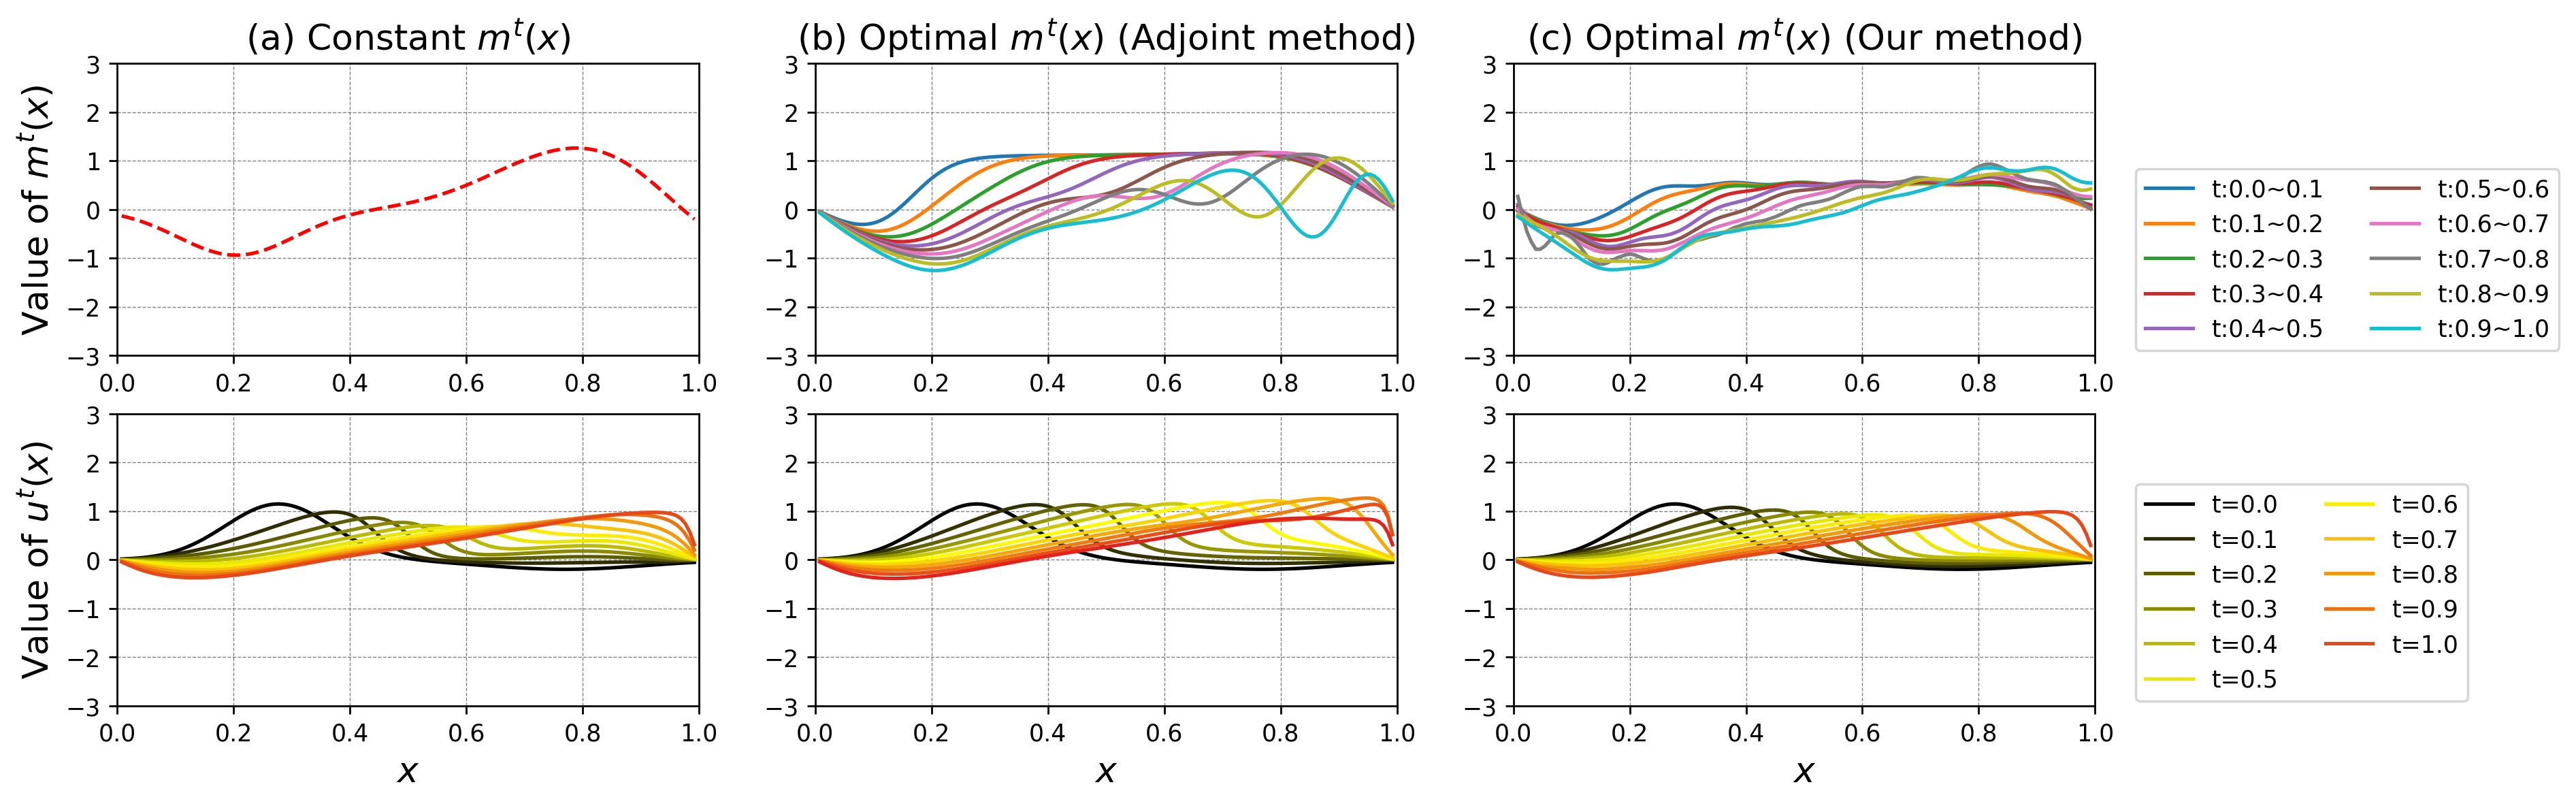

In [17]:
##We choose
idx=85

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=250)
ax=ax.flatten()


#f_const
ax[0].set_title(r'(a) Constant $m^t(x)$', size=15)
ax[0].plot(x,logs['f_const'][idx],'--', c='r', label='Constant F(x)')
ax[0].grid(True, lw=0.4, ls="--", c=".50")
ax[0].set_xlim(0,1)
ax[0].set_ylim(-3,3)
ax[0].set_ylabel(r"Value of $m^t(x)$", fontsize=15)

#f_numeric
ax[1].set_title(r'(b) Optimal $m^t(x)$ (Adjoint method)', size=15)
for i in np.arange(0,100,10):
    ax[1].plot(x,logs['f_numerical'][idx][i], label='t='+str(round(0.1*i,2))+'~'+str(round(0.1*(i+1),2)))
ax[1].grid(True, lw=0.4, ls="--", c=".50")
ax[1].set_xlim(0,1)
ax[1].set_ylim(-3,3)


#f_nn
ax[2].set_title(r'(c) Optimal $m^t(x)$ (Our method)', size=15)
for i in range(num_t):
    ax[2].plot(x,logs['f_nn'][idx][i], label='t='+str(round(0.1*i,2))+'~'+str(round(0.1*(i+1),2)))
ax[2].grid(True, lw=0.4, ls="--", c=".50")
ax[2].set_xlim(0,1)
ax[2].set_ylim(-3,3)
ax[2].legend(legend_force, bbox_to_anchor=(1.05, 0.68), ncol=2)



#u_const
for idx_t in range(num_t+1):
    ax[3].plot(x, logs['u_const'][idx][idx_t], color=cmap(idx_t/(num_t+1)))
ax[3].grid(True, lw=0.4, ls="--", c=".50")
ax[3].set_xlim(0,1)
ax[3].set_ylim(-3,3)  
ax[3].set_ylabel(r"Value of $u^t(x)$", fontsize=15)
ax[3].set_xlabel(r'$x$', fontsize=15)



#u_numeric
for idx_t in np.arange(0,num_t_numeric+1,num_t):
    ax[4].plot(x, logs['u_numerical'][idx][idx_t], color=cmap(idx_t/(num_t_numeric+1)))
ax[4].grid(True, lw=0.4, ls="--", c=".50")
ax[4].set_xlim(0,1)
ax[4].set_ylim(-3,3)
ax[4].set_xlabel(r'$x$', fontsize=15)


#u_nn
for idx_t in range(num_t+1):
    ax[5].plot(x, logs['u_nn'][idx][idx_t].detach(), color=cmap(idx_t/(num_t+1)))
ax[5].grid(True, lw=0.4, ls="--", c=".50")
ax[5].set_xlim(0,1)
ax[5].set_ylim(-3,3)
ax[5].set_xlabel(r'$x$', fontsize=15)
ax[5].legend(legend_state, bbox_to_anchor=(1.05, 0.8), ncol=2)

# colorscale
#cb = fig.colorbar(hexbins, ax=ax)
#cb.set_label('Color Scale')
#plt.savefig('ex2.png', dpi=300)
plt.show()